# Imports

In [6]:
import time
import urllib3
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [7]:
urllib3.disable_warnings()
tfds.disable_progress_bar()
tf.enable_eager_execution()

In [22]:
tf.logging.set_verbosity(tf.logging.ERROR)

# Load Cat vs Dog Dataset

In [37]:
(training, validation), info = tfds.load('cats_vs_dogs',
                                             split=['train[:80%]', 'train[80%:]'],
                                             with_info=True,
                                             as_supervised=True)

    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


In [38]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE, IMAGE))/255.0
    return image, label

num_examples = info.splits['train'].num_examples
print("Number of examples:", num_examples)

Number of examples: 23262


In [39]:
# mobilenet expects 224x224 images
BATCH = 32
IMAGE = 224

# Image Input Pipeline

In [40]:
train_batches = training.cache().shuffle(num_examples//4).map(format_image).batch(BATCH).prefetch(1)
validate_batches = validation.cache().map(format_image).batch(BATCH).prefetch(1)

# Define Feature Extractor

In [41]:
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(url, input_shape=(IMAGE, IMAGE, 3))

# Freeze Base Model

In [42]:
feature_extractor.trainable = False

# Add Output Layer

In [43]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2)
])

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Train Model

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 3

In [46]:
log = model.fit(train_batches, epochs=EPOCHS, validation_data=validate_batches)

Epoch 1/3
582/582 [==============================] - 21s 36ms/step - loss: 0.0537 - acc: 0.9821 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 18s 30ms/step - loss: 0.0321 - acc: 0.9898 - val_loss: 0.0341 - val_acc: 0.9875
Epoch 3/3
582/582 [==============================] - 18s 30ms/step - loss: 0.0271 - acc: 0.9913 - val_loss: 0.0335 - val_acc: 0.9873


# Check Predictions

In [48]:
class_names = np.array(info.features['label'].names)
print(class_names)

['cat' 'dog']


In [49]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [57]:
predictions = model.predict(image_batch)
predictions = tf.squeeze(predictions).numpy()
prediction_labels = np.argmax(predictions, axis=-1)
prediction_names = class_names[prediction_labels]
print(prediction_names)

['cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat'
 'cat' 'cat' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'cat' 'dog'
 'cat' 'cat' 'dog' 'cat' 'cat' 'dog' 'cat' 'dog']


In [58]:
print("Actual   : ", label_batch)
print("Predicted: ", prediction_labels)

Actual   :  [0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1]
Predicted:  [0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1]


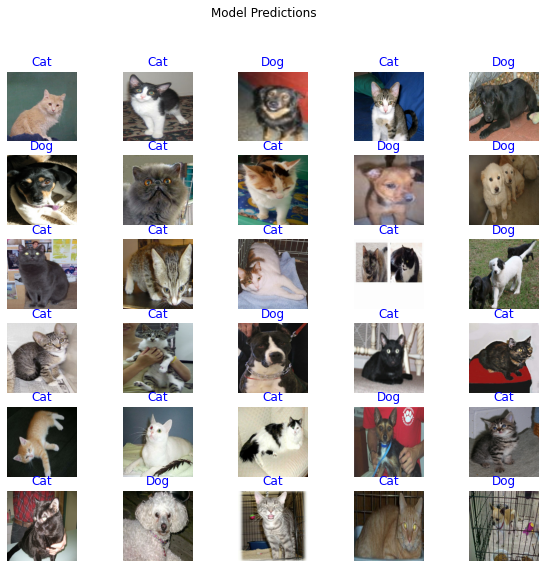

In [59]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = 'blue' if prediction_labels[n] == label_batch[n] else 'red'
    plt.title(prediction_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle('Model Predictions')

# Save .h5 Model

In [60]:
t = time.time()
export_path = "./cat_dog_{}.h5".format(int(t))
print(export_path)

./cat_dog_1593615699.h5


In [61]:
model.save(export_path)

# Load .h5 Model 

In [68]:
reload = tf.keras.models.load_model(
    export_path,
    # keras instructions for loading
    custom_objects = {'KerasLayer':hub.KerasLayer}
)

In [69]:
reload.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Confirm Equality

In [63]:
results = model.predict(image_batch)
reload_results = reload.predict(image_batch)
(abs(results - reload_results)).max()

0.0

# Continue Training

In [64]:
EPOCHS = 3
log = reload.fit(train_batches, epochs=EPOCHS, validation_data=validate_batches)

Epoch 1/3
582/582 [==============================] - 20s 35ms/step - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 18s 30ms/step - loss: 0.0211 - acc: 0.9943 - val_loss: 0.0342 - val_acc: 0.9882
Epoch 3/3
582/582 [==============================] - 17s 30ms/step - loss: 0.0190 - acc: 0.9948 - val_loss: 0.0345 - val_acc: 0.9890


# Export SavedModel

In [74]:
t = time.time()
model_export_path = "./cat_dog_{}".format(int(t))
print(export_path)

./cat_dog_1593616496


In [75]:
tf.saved_model.save(reload, model_export_path)

In [76]:
!ls {model_export_path}

assets	saved_model.pb	variables


# Load SavedModel

In [89]:
loaded = tf.compat.v2.saved_model.load(model_export_path)

In [90]:
loaded_result_batch = loaded(image_batch, training=False).numpy()

In [91]:
(abs(results - loaded_result_batch)).max()

0.0

# Load SavedModel as Keras Model

In [102]:
saved_model = tf.keras.models.load_model(
    model_export_path,
    custom_objects={'KerasLayer': hub.KerasLayer}
)

In [103]:
model_results = reload.predict(image_batch)
saved_model_results = saved_model.predict(image_batch)

In [104]:
(abs(model_results - saved_model_results)).max()

0.0

# Download Model

In [107]:
!zip -r model.zip {model_export_path}

  adding: cat_dog_1593616557/ (stored 0%)
  adding: cat_dog_1593616557/saved_model.pb (deflated 93%)
  adding: cat_dog_1593616557/variables/ (stored 0%)
  adding: cat_dog_1593616557/variables/variables.index (deflated 79%)
  adding: cat_dog_1593616557/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: cat_dog_1593616557/variables/variables.data-00000-of-00002 (deflated 88%)
  adding: cat_dog_1593616557/assets/ (stored 0%)
